# Team BackProp

From distribution analysis, it was found that labels 2 and 6 in the data produce the most confusion in predictions from the confusion matrix. Knowing that some characters may look very similar to each other, its clear why the confusion is happening. 

The idea for investigation is to collect up the input features of these two class predictions, then perform a dimensionality reduction and reclassify them on a much simpler model. 

### Imports

In [2]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation,\
                                    ToPILImage, RandomResizedCrop, RandomAffine

from livelossplot import PlotLosses

import csv
import pickle

device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

from google.colab import drive
drive.mount('/content/gdrive/')

# Copy package into current dir
!cp -avr /content/gdrive/My\ Drive/kmnist_helpers/ /content

from kmnist_helpers import seed, set_seed

Cuda installed! Running on GPU!
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
'/content/gdrive/My Drive/kmnist_helpers/__init__.py' -> '/content/kmnist_helpers/__init__.py'
'/content/gdrive/My Drive/kmnist_helpers/propagate.py' -> '/content/kmnist_helpers/propagate.py'
'/content/gdrive/My Drive/kmnist_helpers/tuning.py' -> '/content/kmnist_helpers/tuning.py'
'/content/gdrive/My Drive/kmnist_helpers/ensemble.py' -> '/content/kmnist_helpers/ensemble.py'
'/content/gdrive/My Drive/kmnist_helpers/model_selection.py' -> '/content/kmnist_helpers/model_selection.py'


### KMNIST Data

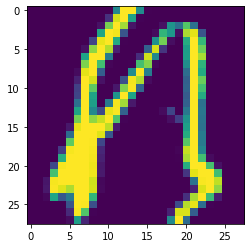

In [4]:
# Load in the datasets
X = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-imgs.npy") /255
y = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-labels.npy")
Xtest = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-test-imgs.npy") /255

# Load in the classmap as a dictionary
classmap = {}
with open('/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist_classmap.csv', 'r') as csvfile:
   spamreader = csv.reader(csvfile, delimiter=',')
   next(spamreader)
   for row in spamreader:
       classmap[row[0]] = row[2]

# Check if we imported correctly
plt.imshow(X[0]);

### Image Preprocessing and Augmentation

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None, mean=False, std=False):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data.reshape(-1,1,28,28)
        self.targets = targets
        self.transform = transform

        # Find mean and standard dev
        self.mean = mean
        self.std = std

        self.Rotation = Compose([
                                  ToPILImage(),
                                   RandomRotation(10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])

        self.RotandCrop = Compose([
                                  ToPILImage(),
                                   RandomResizedCrop(size=(28,28), scale=(0.8,1)),
                                  ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                 ])
        
        self.Affine = Compose([ToPILImage(),
                                   RandomAffine(10, shear=10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])
 
        
        self.Norm = Compose([Normalize(mean=[self.mean], std=[self.std])
                                 ])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        assert (self.mean != False), "Asign a mean"
        assert (self.mean != False), "Asign a std"
        
        if self.transform:
            x = random.random()
            if 0<= x<0.2: # rotate
              sample = self.Rotation(sample)
            if 0.2<= x<0.4: # resize crop
              sample = self.RotandCrop(sample)
            if 0.4<= x<0.7: # shear crop
              sample= self.Affine(sample)
              
            else: # none
              sample = self.Norm(sample)
        else:
           sample = self.Norm(sample)
            
        return sample, label

torch.Size([25, 1, 28, 28])
max: tensor(6.1103)


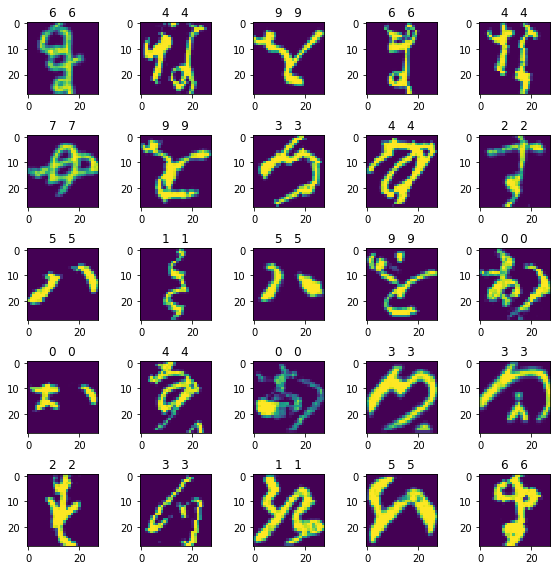

In [6]:
# Verify if image augmentation works:
X_train, y_train = X.astype(float), y
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
mean1, std1 = torch.mean(X_train), torch.std(X_train)
dset = CustomImageTensorDataset(X_train, y_train, transform=True, mean=mean1, std=std1 )

# Make a dataloader to access the PIL images of a batch size of 25
loader = DataLoader(dset, batch_size=25, shuffle=True)

# Create an iter object to cycle through dataloader
train_iter = iter(loader)
imgs, labels = train_iter.next()

print(imgs.shape)
print('max:',imgs.max())

# plot our batch of images with labels
fig, axarr = plt.subplots(5,5,figsize=(8,8))
fig.tight_layout()
for img, label, axs in zip(imgs, labels, axarr.flatten()):
    axs.set_title(str(label.numpy()) + "   " + str(label.numpy()))
    axs.imshow(img.numpy()[0])

### Cross Validate

In [0]:
class SimpleAlexNet_FINAL(nn.Module):
  def __init__(self):
    super(SimpleAlexNet_FINAL, self).__init__()
    self.conv_1 = nn.Conv2d(1, 36, kernel_size=3, padding=1)
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_3 = nn.Conv2d(36, 72, kernel_size=3)
    self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_5 = nn.Conv2d(72, 142, kernel_size=3, padding=1)
    self.conv_6 = nn.Conv2d(142, 284, kernel_size=3, padding=1)
    self.conv_7 = nn.Conv2d(284, 124, kernel_size=3, padding=1)
    self.pool_8 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear_9 = nn.Linear(1116, 400)
    self.linear_10 = nn.Linear(400, 400)
    self.linear_11 = nn.Linear(400, 10)
    self.dout = nn.Dropout(p=0.7) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    self.b1 = nn.BatchNorm2d(36)
    self.b2 = nn.BatchNorm2d(72)
    self.b3 = nn.BatchNorm2d(142)
    self.b4 = nn.BatchNorm2d(284)
    self.b5 = nn.BatchNorm2d(124)
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b2(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b3(self.conv_5(x)))
    x = self.act(self.b4(self.conv_6(x)))
    x = self.act(self.b5(self.conv_7(x)))
#     x = self.act(self.conv_7(x)) # Added new layer
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_9(x)))
    x = self.act(self.dout(self.linear_10(x)))
   # x = self.dout(x)
    x = self.act(self.linear_11(x))
    
    return x

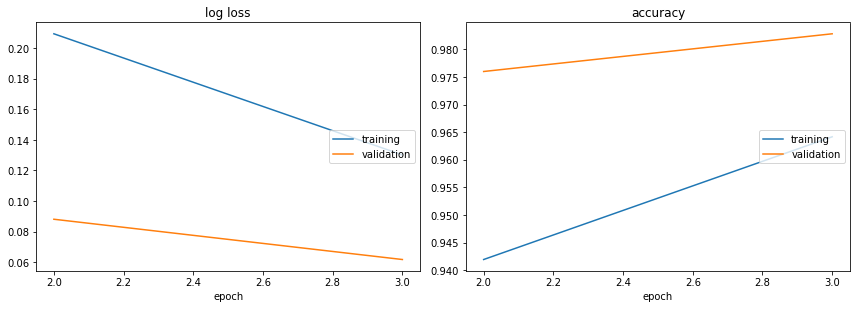

log loss:
training   (min:    0.130, max:    0.959, cur:    0.130)
validation (min:    0.062, max:    0.144, cur:    0.062)

accuracy:
training   (min:    0.685, max:    0.964, cur:    0.964)
validation (min:    0.957, max:    0.983, cur:    0.983)


In [0]:
from kmnist_helpers.model_selection import holdoutCV, holdout_loaders

# training parameters:
batch = 100
testbatch = 1000
epochs = 30

model = SimpleAlexNet_FINAL().to(device)

train_loader, val_loader = holdout_loaders(X, y, CustomImageTensorDataset, 
                                           batch, testbatch)
lloss, val_loss, val_acc = holdoutCV(epochs, 0.0, 1e-4, model,
                                     train_loader, val_loader)

### PCA and K Means Reduction

PCA is one of the most popular transformations, it makes sense to use this first to see what patterns we can find. 
We will focus on only reducing our dimension to 2D as it makes it easier to visualise and saves time from not needing to investigate higher dimensions. 

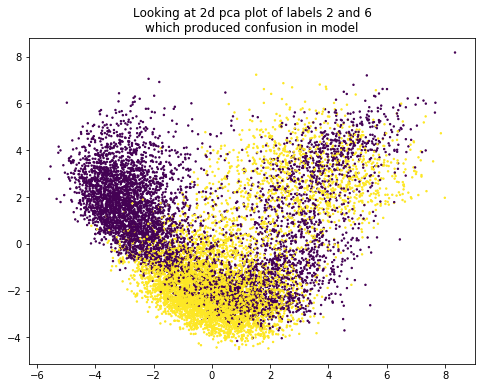

In [8]:
from sklearn.decomposition import PCA

idx = np.where((y==2) | (y==6))

similar_y = y[idx]
similar_X = X[idx]

pca = PCA(n_components=2)
x2d = np.reshape(similar_X, (similar_X.shape[0], -1))
x2d = pca.fit_transform(x2d)

fig, axs = plt.subplots(1,1, figsize=(8,6))
axs.scatter(x2d[:,0], x2d[:,1], s=2, c=similar_y)
axs.set_title('Looking at 2d pca plot of labels 2 and 6\nwhich produced confusion in model');

The reduced data is fairly mixed around the right region. For curiosity, lets see what would happen if we apply kmeans to this.

There are three distinct regions, a strong blue region, a strong yellow region, and finally a somewhat mixed region. 

We will apply 3 centroids to kmeans. 

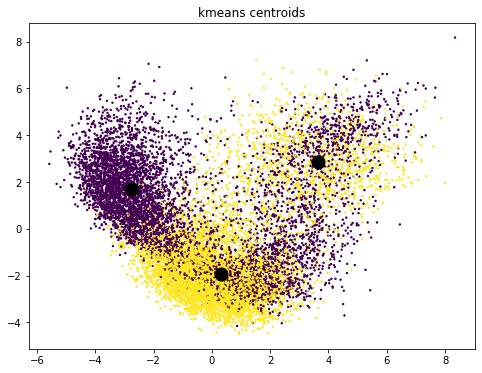

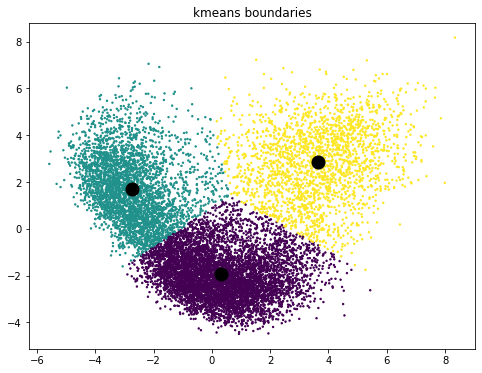

In [9]:
from sklearn.cluster import KMeans

clusters = 3
kmeans = KMeans(n_clusters=clusters, n_init=20, max_iter=600)
kmeans.fit(x2d)
centroids = kmeans.cluster_centers_

fig, axs = plt.subplots(1,1, figsize=(8,6))
axs.scatter(x2d[:,0], x2d[:,1], s=2, c=similar_y)
axs.scatter(centroids[:,0], centroids[:,1], marker='o', s=169, c='k')
axs.set_title('kmeans centroids')

x2dp = kmeans.predict(x2d)

fig, axs = plt.subplots(1,1, figsize=(8,6))
axs.scatter(x2d[:,0], x2d[:,1], s=2, c=x2dp)
axs.scatter(centroids[:,0], centroids[:,1], marker='o', s=169, c='k')
axs.set_title('kmeans boundaries');

It's separated out the identified regions clearly, but predictions wise, this will not be acceptable for our kmnist solution.

### TSNE and Logistic Regression

Another powerful transformation is the TSNE transformation.

After exploration, a perplexity of 3 produces the most distinct boundary.

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=3, random_state=10)
x2d = np.reshape(similar_X, (similar_X.shape[0], -1))
x2d = tsne.fit_transform(x2d)

fig, axs = plt.subplots(1,1, figsize=(8,6))
axs.scatter(x2d[:,0], x2d[:,1], s=2, c=similar_y)
axs.set_title('2d tsne plot of labels 2 and 6\nwhich produced confusion in model')

The boundary line can be separated by a simple logistic regression.

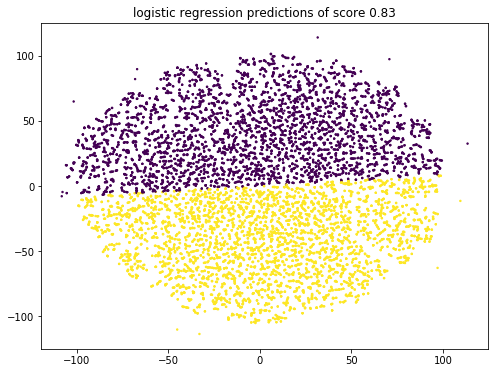

In [11]:
from kmnist_helpers import seed
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=seed, solver='lbfgs',
                         multi_class='multinomial').fit(x2d, similar_y)

train_pred = clf.predict(x2d)

score = clf.score(x2d, similar_y)

fig, axs = plt.subplots(1,1, figsize=(8,6))
axs.scatter(x2d[:,0], x2d[:,1], s=2, c=train_pred)
axs.set_title('logistic regression predictions of score {:.2f}'.format(score));

### T-SNE Reclassification
Data wise, we will only use the given training data X and split this into train and validation sets, to prevent biasing from real test data.

1. Train model
2. Predict model
3. Collect labels 2 and 6 predictions and features
4. Run the T-SNE and logistic regression onto these features
5. Recorrect the original predictions

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

# =============================Load Data========================================
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                    random_state=seed).split(X, y)

indices = [(t, v) for t, v in shuffler][0]

X_train, y_train = X[indices[0]], y[indices[0]]
X_val, y_val = X[indices[1]], y[indices[1]]

X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float() 

mean, std = torch.mean(X_train), torch.std(X_train)

train_ds = CustomImageTensorDataset(X_train, y_train.long(), transform=True, mean=mean, std=std)
test_ds = CustomImageTensorDataset(X_test, y_test.long(), transform=False, mean=mean, std=std)

batch = 100
testbatch = 1000
train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=testbatch, shuffle=False, num_workers=0)

# =============================Train Model======================================

epochs = 30
model = SimpleAlexNet_FINAL().to(device)
set_seed(42)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999),
                             eps=1e-08, weight_decay=0.0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
    liveloss.update(logs)
    liveloss.draw()

# ===================Train T-SNE and Logistic Regression========================

idx = np.where((y_train==2) | (y_train==6))
ytrainsim = y[idx]
Xtrainsim = X[idx]

tsne = TSNE(n_components=2, perplexity=3, random_state=)
xtrain2d = np.reshape(Xtrainsim, (Xtrainsim.shape[0], -1))
xtrain2d = tsne.fit_transform(xtrain2d)

clf = LogisticRegression(random_state=seed, solver='lbfgs',
                         multi_class='multinomial').fit(xtrain2d, ytrainsim)

# ===========================T-SNE Recorrection=================================

y_predictions, y_true = evaluate(model, test_loader)
idx = np.where((y_predictions==2) | (y_predictions==6))

ysim = y_predictions[idx]
Xsim = X_test[idx]

Xsim2d = np.reshape(Xsim, (Xsim.shape[0], -1))
Xsim2d = tsne.transform(Xsim2d)

y_predictions[idx] = clf.predict(Xsim2d)

# =============================Score Model======================================

score = accuracy_score(y_predictions, y_true)
print("Validation accuracy: ", score)

submit = np.vstack((np.array(_), np.array(y_predictions)))
submit = submit.transpose()